[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 2979, number of used features: 7
[LightGBM] [Info] Start training from score 4.383223
Root Mean Squared Error: 4.370383900747044


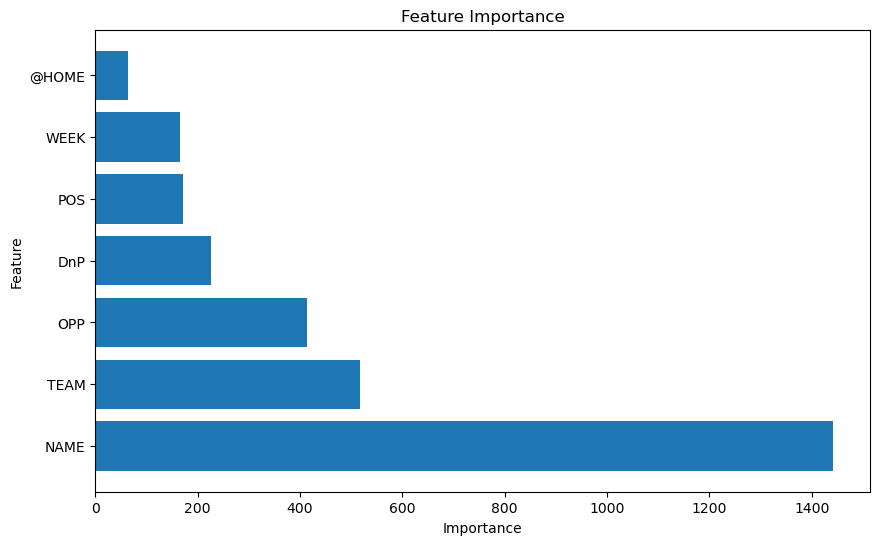

In [4]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import joblib

# Load your DataFrame
data = pd.read_csv('WK_1-6.csv')  # Replace 'your_data.csv' with the actual file path
data = data.dropna(subset=['WON'])

columns_to_check = [
    "PASS_COMP", "PASS_YDS", "PASS_TD", "INT",
    "CAR", "RUSH_YDS", "RUSH_TD", "REC",
    "REC_YARDS", "REC_TD", "TARGETS", "2PC",
    "FUML", "MISC_TD"
]
data["DnP"] = (data[columns_to_check] == 0).all(axis=1)

# Define the features and target variable
features = ['NAME', 'POS', 'TEAM', 'OPP', '@HOME', 'WEEK', 'DnP']
target = 'FPTS'

label_encoders = {}
categorical_columns = ['POS', 'TEAM', 'OPP', 'NAME', '@HOME', 'DnP']
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Sort your data by week
data.sort_values(by='WEEK', inplace=True)

# Split the data by week
train_data = data[data['WEEK'] <= 5]  # Use the first four weeks for training
test_data = data[data['WEEK'] == 6]   # Use the fifth week for testing

# Separate features and target variables for training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Create and train the LightGBM model
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using RMSE (Root Mean Squared Error)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# Get feature importances from the model
feature_importance = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()





In [8]:
import json

# Save the LightGBM model to a JSON file
def save_lightgbm_model(model, model_path):
    model.booster_.save_model(model_path)

from sklearn.preprocessing import LabelEncoder

# Save the label encoders to a JSON file
def save_label_encoders(label_encoders, label_encoders_path):
    # Convert LabelEncoder objects to dictionaries
    label_encoders_dict = {column: label_encoder.classes_.tolist() for column, label_encoder in label_encoders.items()}
    
    # Save the dictionaries to a JSON file
    with open(label_encoders_path, 'w') as label_encoders_file:
        json.dump(label_encoders_dict, label_encoders_file)

# Save the model and label encoders to JSON files
# Save the model to a JSON file

save_lightgbm_model(model, 'lightgbm_model.json')
# Save the label encoders to a JSON file
save_label_encoders(label_encoders, 'label_encoders1-5.json')

In [ ]:
df = pd.read_csv('WK_1-6.csv')
unique_teams = df['TEAM'].unique()
print(unique_teams)

position_group = 'QB'  # Replace with the desired position group
# Filter the DataFrame to include only the desired position group
filtered_df = df[df['POS'] == position_group]
# Get the unique players from the filtered DataFrame
unique_players = filtered_df['NAME'].unique()
# Print the unique players in the specified position group
df.head()

In [ ]:

# Create a new data point for prediction with the same features
player = 'Jerome Ford'
position = 'RB'
team = 'Cle'
Opp = 'Ind'
at_home = False
week = 7
DnP = False
new_data_point = {
    'NAME': label_encoders['NAME'].transform([player])[0],
    'POS': label_encoders['POS'].transform([position])[0],
    'TEAM': label_encoders['TEAM'].transform([team])[0],
    'OPP': label_encoders['OPP'].transform([Opp])[0], 
    '@HOME': label_encoders['@HOME'].transform([at_home])[0], 
    'WEEK': week,
    'DnP': label_encoders['DnP'].transform([DnP])[0]
}
# Create a DataFrame with the new data point
new_data_df = pd.DataFrame([new_data_point])
# Use the model to make predictions
predicted_fpts = model.predict(new_data_df)
# Display the predicted fantasy points
print(f"Predicted points: {player} {predicted_fpts[0]:.2f}")